## import libraries

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
env = gym.make('CartPole-v0')

In [2]:
class ActorCriticModel(nn.Module):

  def __init__(self, n_input, n_output, n_hidden):
    super(ActorCriticModel, self).__init__()
    self.fc = nn.Linear(n_input, n_hidden)
    self.action = nn.Linear(n_hidden, n_output)
    self.value = nn.Linear(n_hidden, 1)

  def forward(self, x):
    x = torch.Tensor(x)
    x = F.relu(self.fc(x))
    action_probs = F.softmax(self.action(x), dim=-1)
    state_values = self.value(x)
    return action_probs, state_values

In [3]:
class PolicyNetwork():

  def __init__(self, n_state, n_action, n_hidden=50, lr=0.001):

    self.model = ActorCriticModel(n_state, n_action, n_hidden)
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
    self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.9)
  
  def predict(self, s):
    return self.model(torch.Tensor(s))
  
  def update(self, returns, log_probs, state_values):
    loss = 0
    for log_prob, value, Gt in zip(log_probs, state_values, returns):
      advantage = Gt - value.item()
      policy_loss = -log_prob * advantage
      value_loss = F.smooth_l1_loss(value, Gt)
      loss += policy_loss + value_loss
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def get_action(self, s):
    action_probs, state_value = self.predict(s)
    action = torch.multinomial(action_probs, 1).item()
    log_prob = torch.log(action_probs[action])
    return action, log_prob, state_value
  
  

In [4]:
def actor_critic(env, estimator, n_episode, gamma=1.0):

  for episode in range(n_episode):
    log_probs = []
    rewards = []
    state_values = []
    state = env.reset()
    while True:
      action, log_prob, state_value = estimator.get_action(state)
      next_state, reward, is_done, _ = env.step(action)
      total_reward_episode[episode] += reward
      log_probs.append(log_prob)
      state_values.append(state_value)
      rewards.append(reward)
      if is_done:
        returns = []
        Gt = 0
        pw = 0
        for reward in rewards[::-1]:
          Gt += gamma ** pw * reward
          pw += 1
          returns.append(Gt)
        returns = returns[::-1]
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        estimator.update(returns, log_probs, state_values)
        print('Episode: {}, total reward: {}'.format(episode, total_reward_episode[episode]))
        if total_reward_episode[episode] >= 195:
          estimator.scheduler.step()
        break
      state = next_state

In [5]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 128
lr = 0.03
policy_net = PolicyNetwork(n_state, n_action, n_hidden, lr)

In [6]:
gamma = 0.9
n_episode = 1000
total_reward_episode = [0] * n_episode
actor_critic(env, policy_net, n_episode, gamma)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Episode: 0, total reward: 10.0
Episode: 1, total reward: 10.0
Episode: 2, total reward: 9.0
Episode: 3, total reward: 10.0
Episode: 4, total reward: 10.0
Episode: 5, total reward: 9.0
Episode: 6, total reward: 9.0
Episode: 7, total reward: 10.0
Episode: 8, total reward: 10.0
Episode: 9, total reward: 9.0
Episode: 10, total reward: 9.0
Episode: 11, total reward: 10.0
Episode: 12, total reward: 8.0
Episode: 13, total reward: 9.0
Episode: 14, total reward: 10.0
Episode: 15, total reward: 9.0
Episode: 16, total reward: 9.0
Episode: 17, total reward: 10.0
Episode: 18, total reward: 11.0
Episode: 19, total reward: 8.0
Episode: 20, total reward: 10.0
Episode: 21, total reward: 10.0
Episode: 22, total reward: 8.0
Episode: 23, total reward: 10.0
Episode: 24, total reward: 10.0
Episode: 25, total reward: 10.0
Episode: 26, total reward: 10.0
Episode: 27, total reward: 8.0
Episode: 28, total reward: 9.0
Episode: 29, total reward: 9.0
Episode: 30, total reward: 10.0
Episode: 31, total reward: 9.0
E

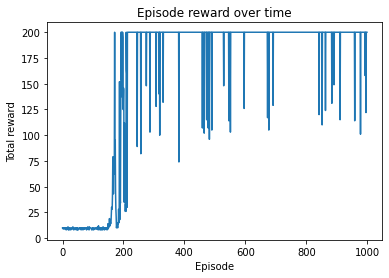

In [7]:
import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

## Helpful resources
[STEPLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html)

[SMOOTHL1LOSS](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html) 
